# Import necessary Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Add this import
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [35]:
# Read and preprocess the data
df = pd.read_csv("MSFT_storico.csv", skiprows=2)
df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

# Data Preprocessing

In [36]:




# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Rest of the preprocessing code remains the same
print("Initial data shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

# Handle missing values if any
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

# Sort by date
df = df.sort_index()

# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

# Handle outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[f'{column}_outlier'] = ~df[column].between(lower_bound, upper_bound)
    return df

for column in ['Close', 'High', 'Low', 'Open', 'Volume']:
    df = remove_outliers(df, column)

# Calculate additional features
df['Returns'] = df['Close'].pct_change()
df['Log_Returns'] = np.log(df['Close']/df['Close'].shift(1))
df['Rolling_Mean'] = df['Close'].rolling(window=20).mean()
df['Rolling_Std'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['Rolling_Mean'] + (df['Rolling_Std'] * 2)
df['Lower_Band'] = df['Rolling_Mean'] - (df['Rolling_Std'] * 2)

Initial data shape: (731, 5)

Missing values:
 Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


# Exploratory Data Analysis (EDA)

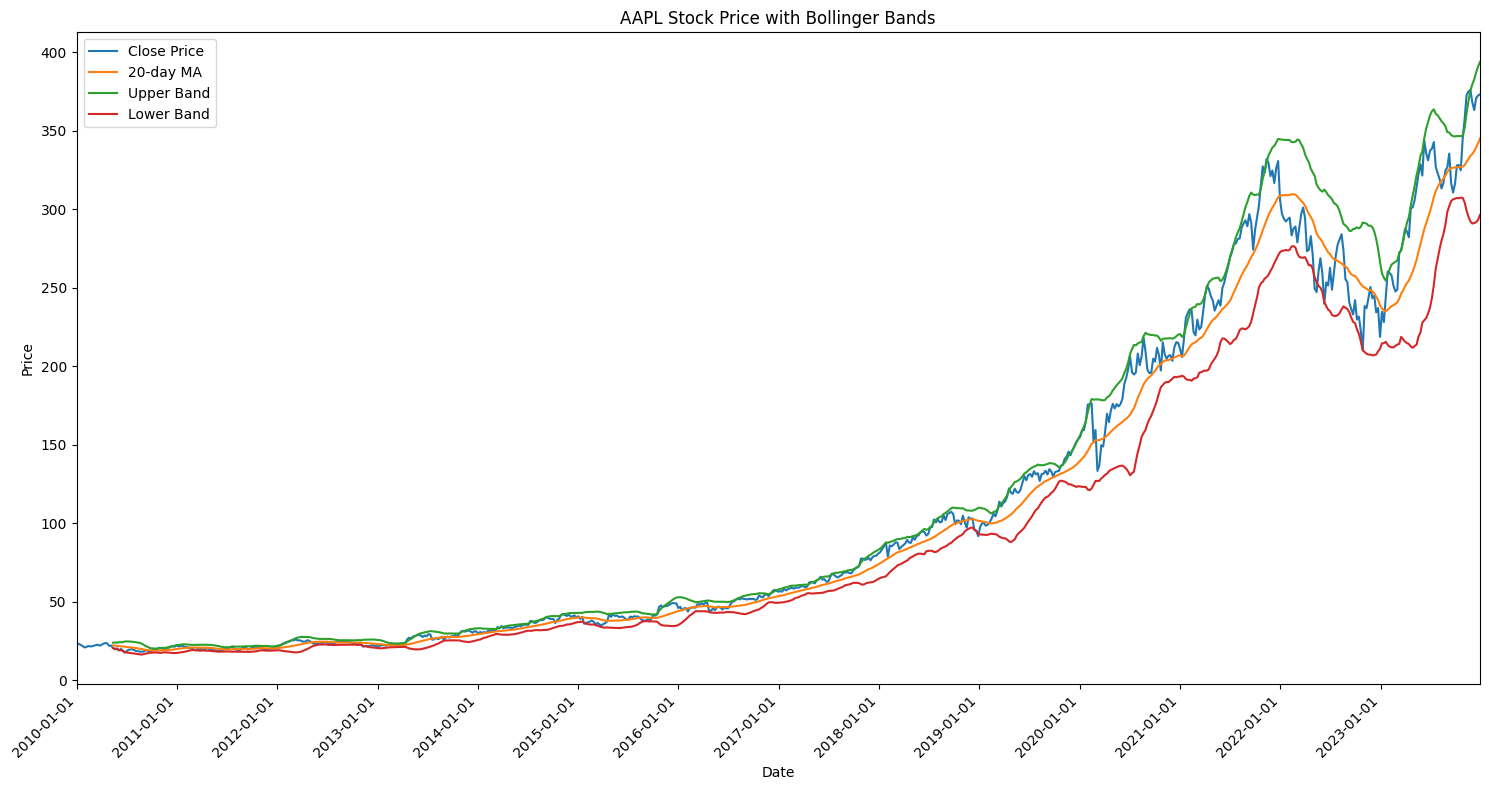

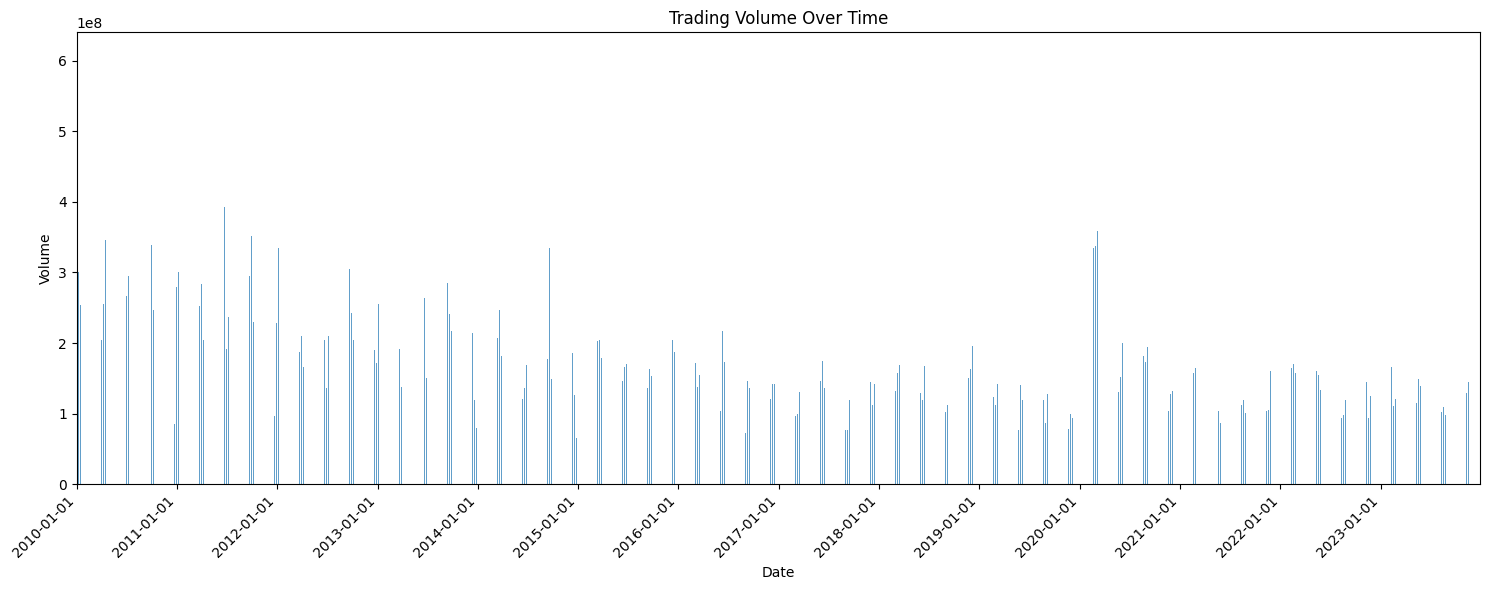

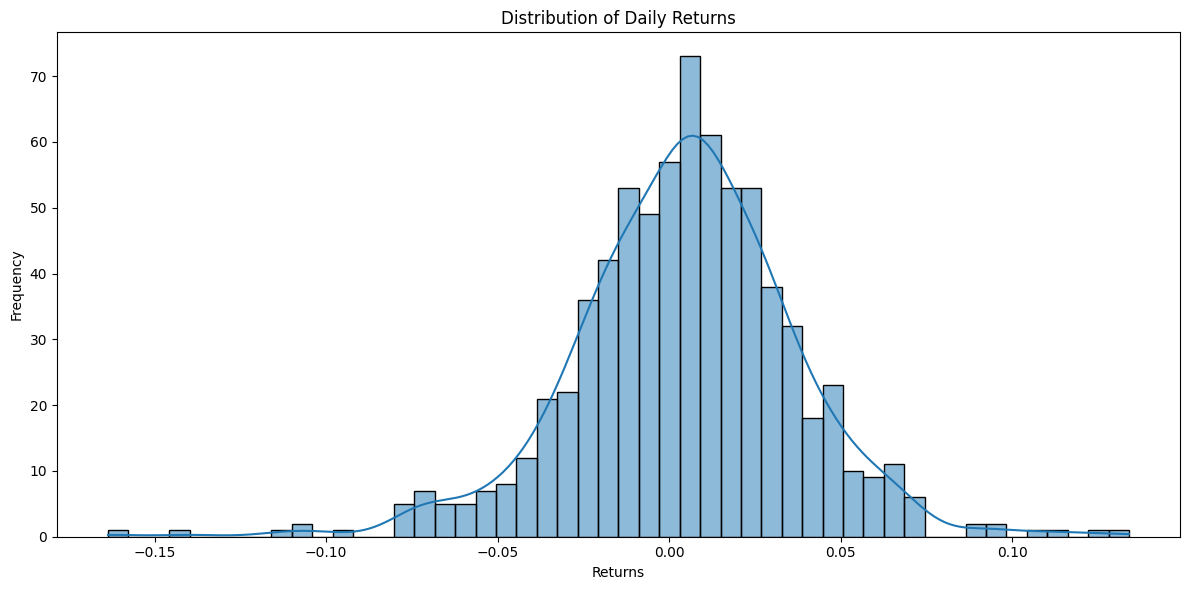

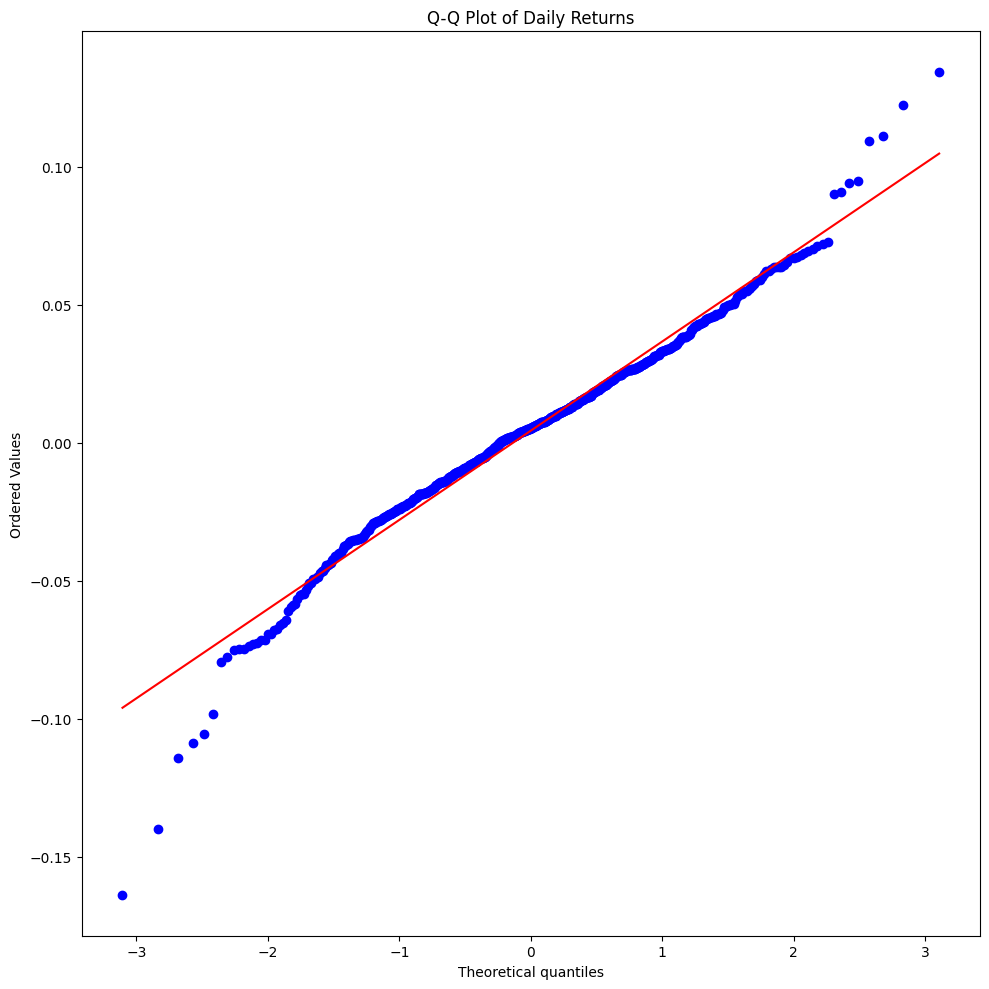

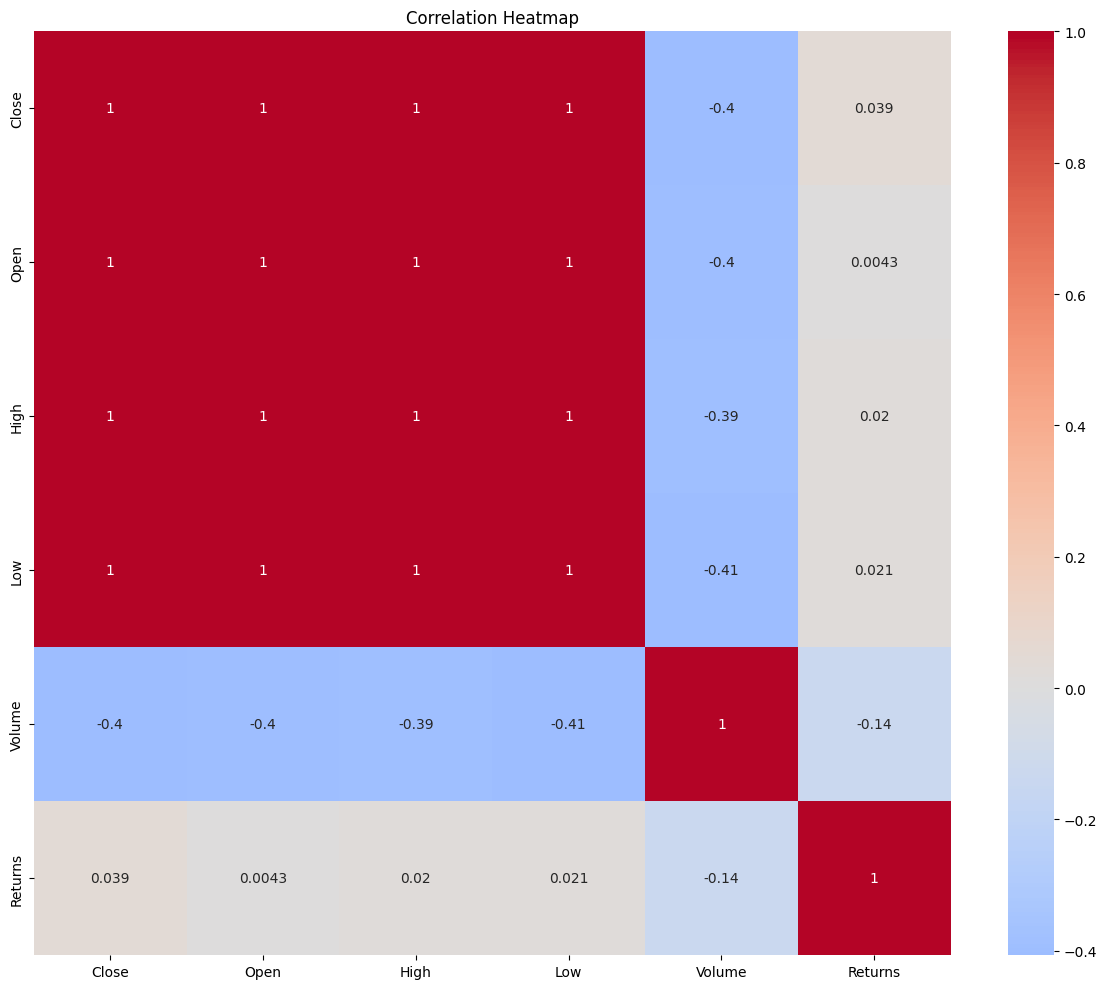

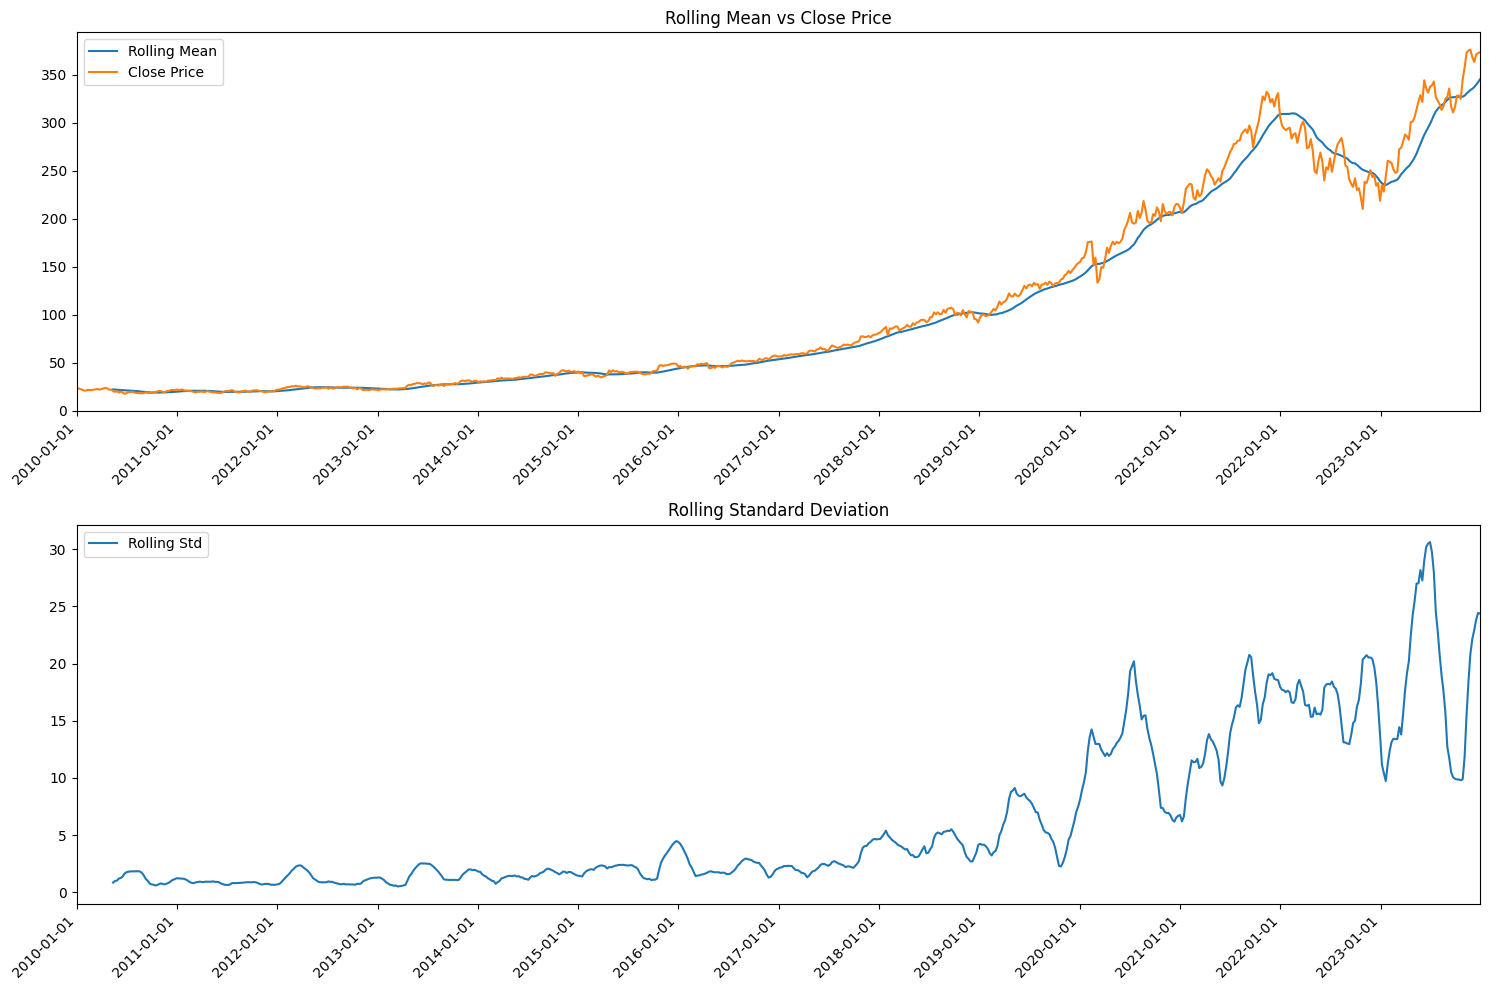

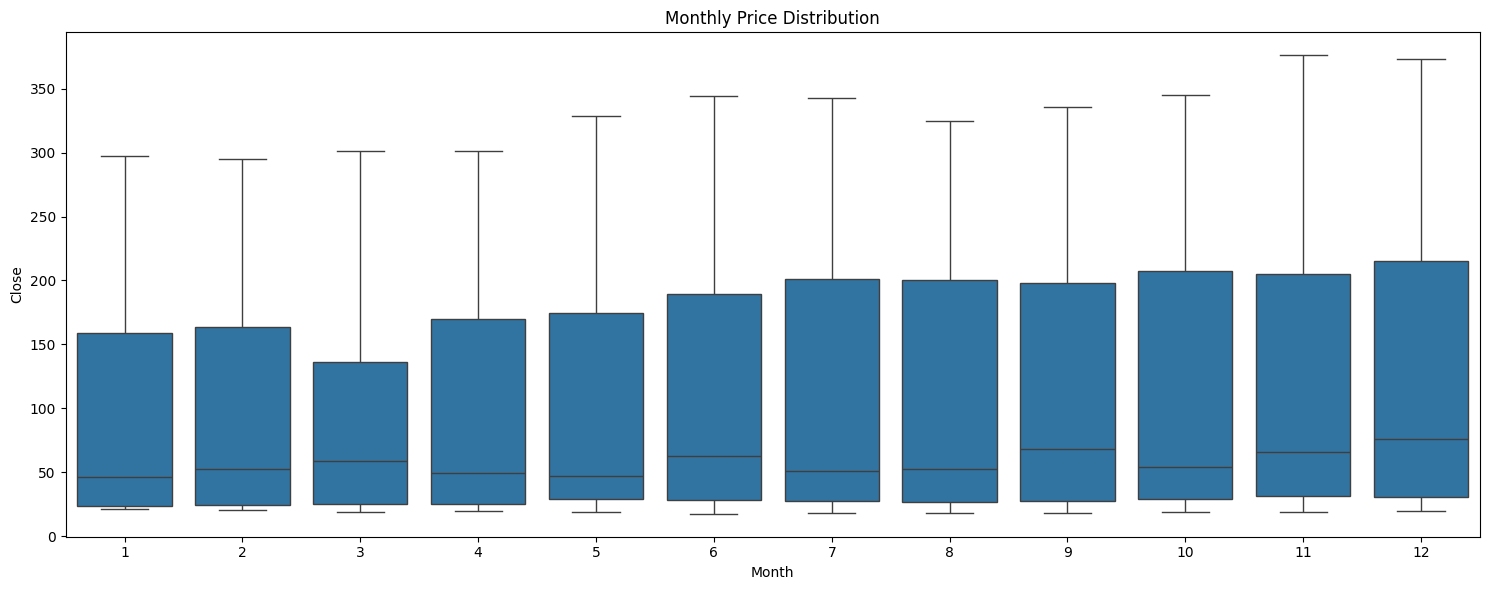

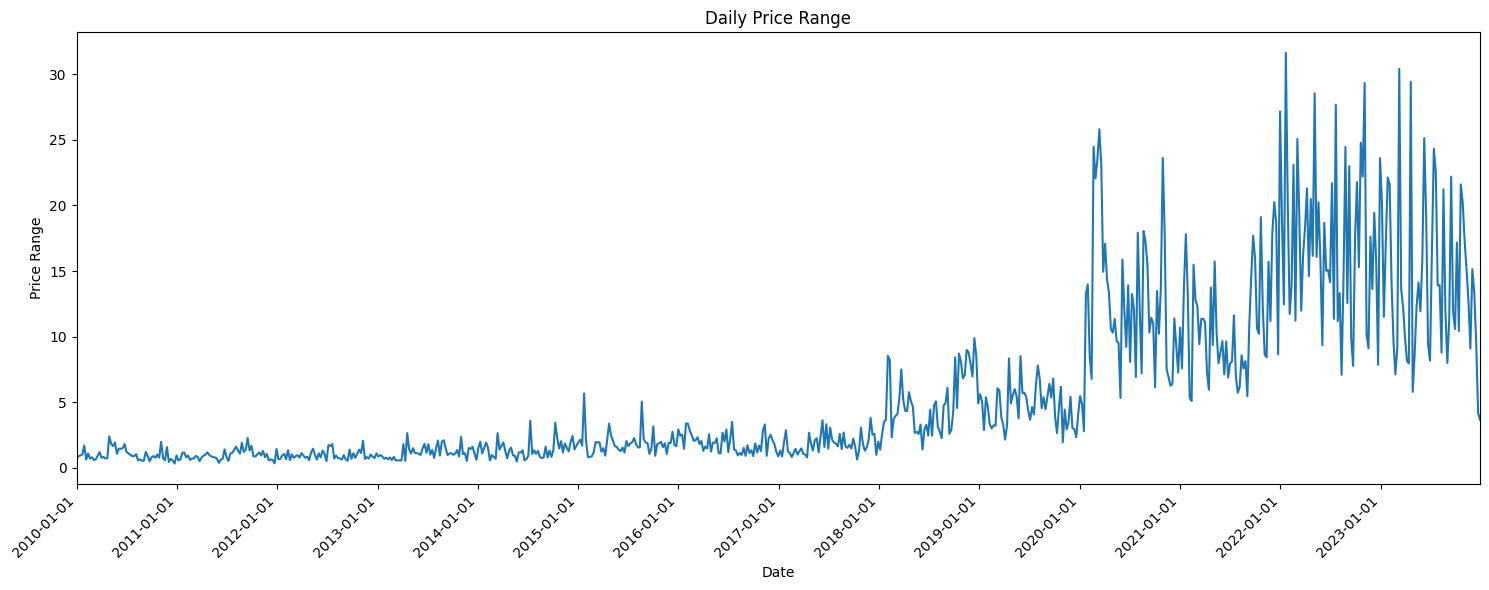

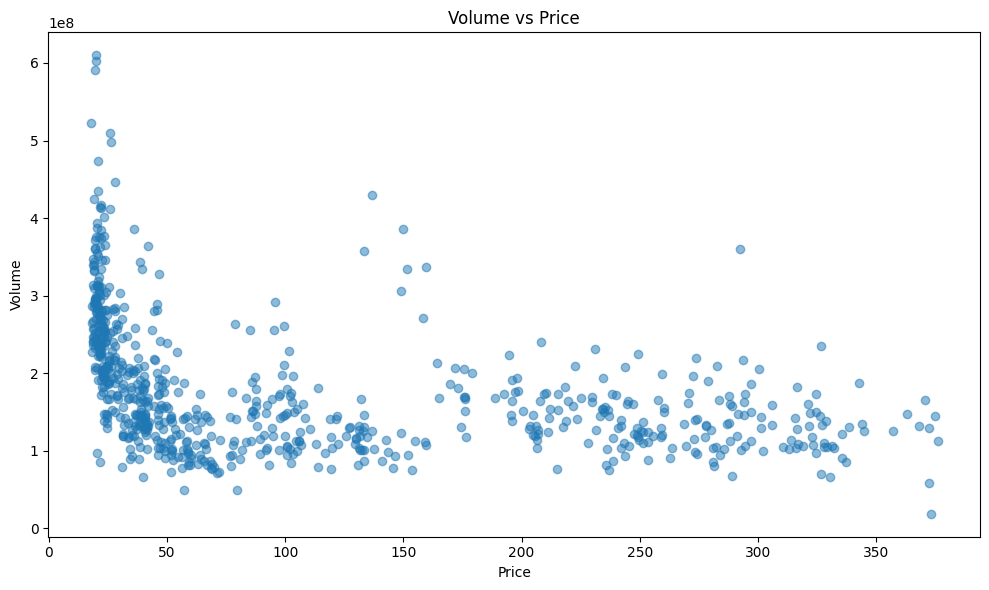

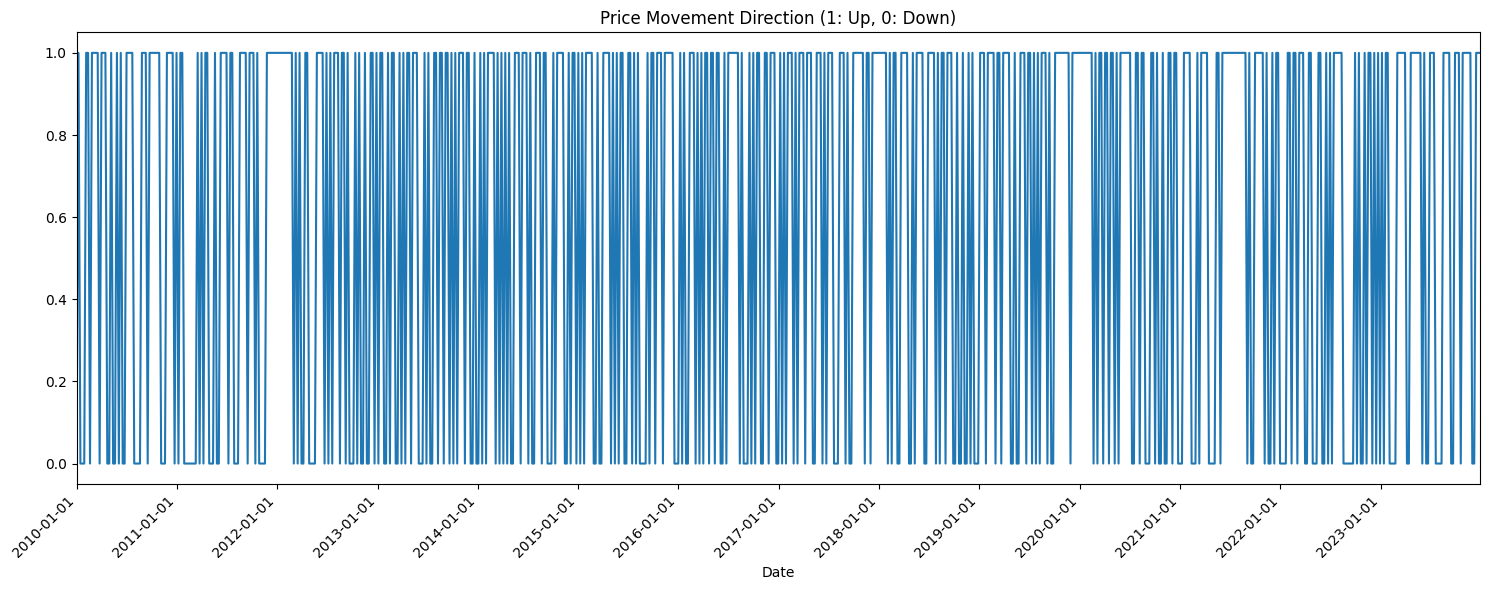

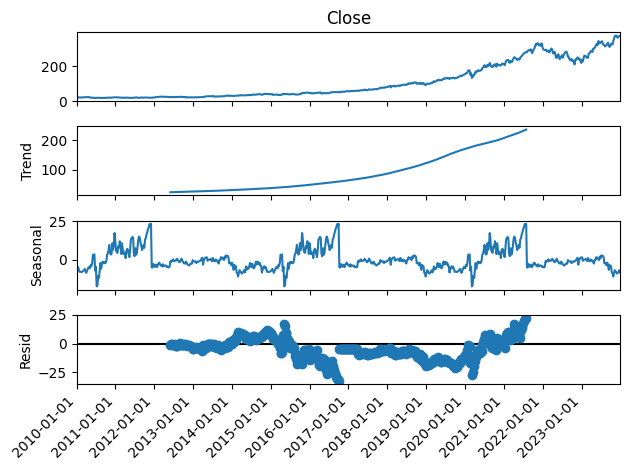

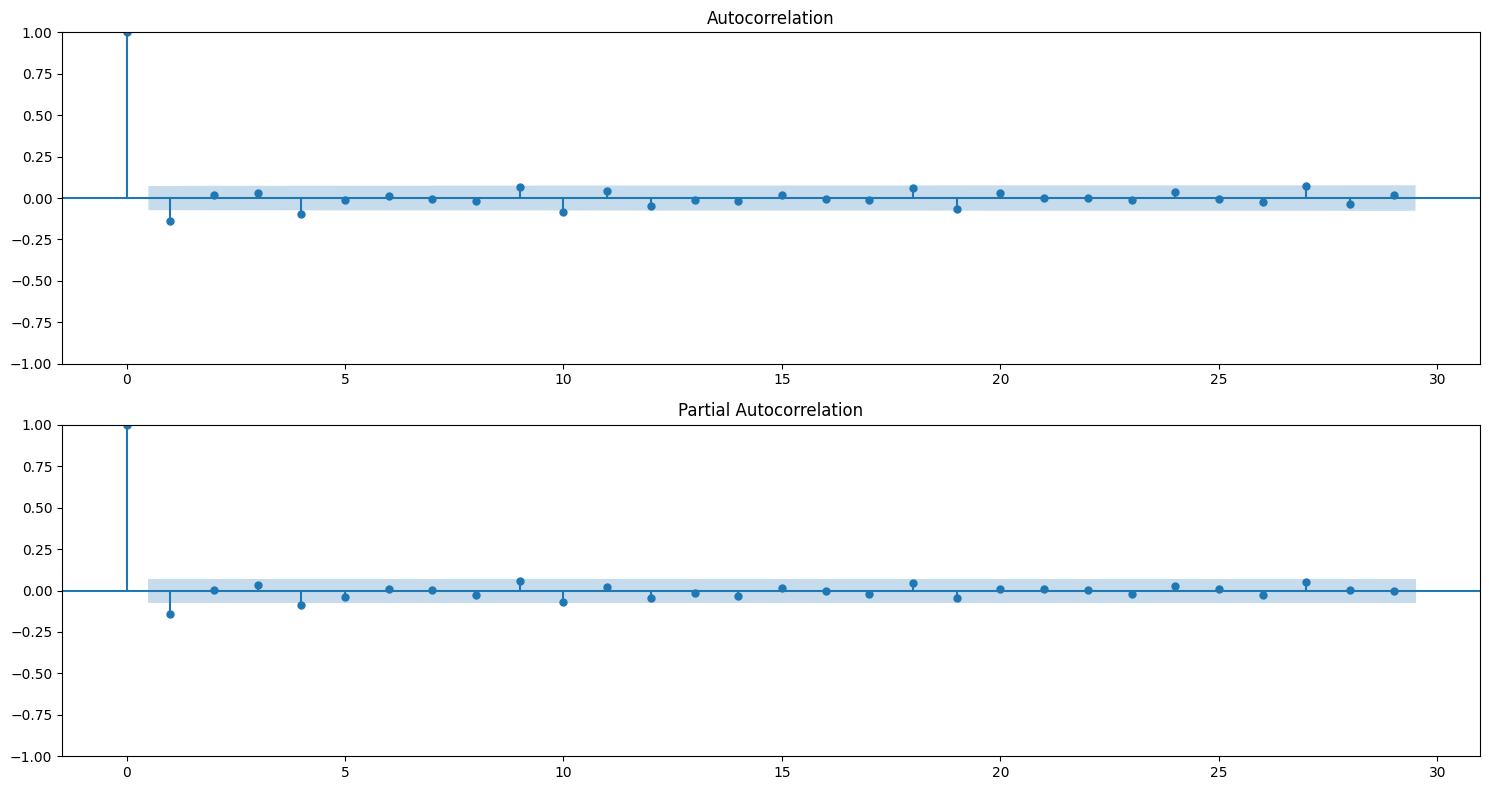

In [37]:
# Updated function to format dates on x-axis
def format_date_axis(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
     # Set the x-axis limits to match your data range
    ax.set_xlim(df.index[0], df.index[-1])

# 1. Time Series Plot with Bollinger Bands
plt.figure(figsize=(15, 8))
ax = plt.gca()
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['Rolling_Mean'], label='20-day MA')
plt.plot(df.index, df['Upper_Band'], label='Upper Band')
plt.plot(df.index, df['Lower_Band'], label='Lower Band')
plt.title('AAPL Stock Price with Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
format_date_axis(ax)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Volume Analysis
plt.figure(figsize=(15, 6))
ax = plt.gca()
plt.bar(df.index, df['Volume'], alpha=0.7)
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
format_date_axis(ax)
plt.tight_layout()
plt.show()

# 3. Daily Returns Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Returns'].dropna(), bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 4. QQ Plot for Returns
from scipy import stats
plt.figure(figsize=(10, 10))
stats.probplot(df['Returns'].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Daily Returns")
plt.tight_layout()
plt.show()

# 5. Correlation Matrix Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[['Close', 'Open', 'High', 'Low', 'Volume', 'Returns']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# 6. Rolling Statistics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(df.index, df['Rolling_Mean'], label='Rolling Mean')
ax1.plot(df.index, df['Close'], label='Close Price')
ax1.set_title('Rolling Mean vs Close Price')
format_date_axis(ax1)
ax1.legend()

ax2.plot(df.index, df['Rolling_Std'], label='Rolling Std')
ax2.set_title('Rolling Standard Deviation')
format_date_axis(ax2)
ax2.legend()
plt.tight_layout()
plt.show()

# 7. Monthly Box Plot
df['Month'] = df.index.month
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month', y='Close', data=df)
plt.title('Monthly Price Distribution')
plt.tight_layout()
plt.show()

# 8. Daily Price Range
plt.figure(figsize=(15, 6))
ax = plt.gca()
plt.plot(df.index, df['High'] - df['Low'])
plt.title('Daily Price Range')
plt.xlabel('Date')
plt.ylabel('Price Range')
format_date_axis(ax)
plt.tight_layout()
plt.show()

# 9. Volume vs Price Scatter
plt.figure(figsize=(10, 6))
plt.scatter(df['Close'], df['Volume'], alpha=0.5)
plt.title('Volume vs Price')
plt.xlabel('Price')
plt.ylabel('Volume')
plt.tight_layout()
plt.show()

# 10. Price Movement Direction
plt.figure(figsize=(15, 6))
ax = plt.gca()
plt.plot(df.index, np.where(df['Returns'] > 0, 1, 0))
plt.title('Price Movement Direction (1: Up, 0: Down)')
plt.xlabel('Date')
format_date_axis(ax)
plt.tight_layout()
plt.show()

# 11. Decomposition Plot
decomposition = seasonal_decompose(df['Close'], period=252)
fig = decomposition.plot()
for ax in fig.axes:
    format_date_axis(ax)
plt.tight_layout()
plt.show()

# 12. Log Returns ACF/PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(df['Log_Returns'].dropna(), ax=ax1)
plot_pacf(df['Log_Returns'].dropna(), ax=ax2)
plt.tight_layout()
plt.show()


# Time Series Trend using ARIMA

Stationarity Test for Log Returns:
ADF Statistic: -31.01179279142712
p-value: 0.0


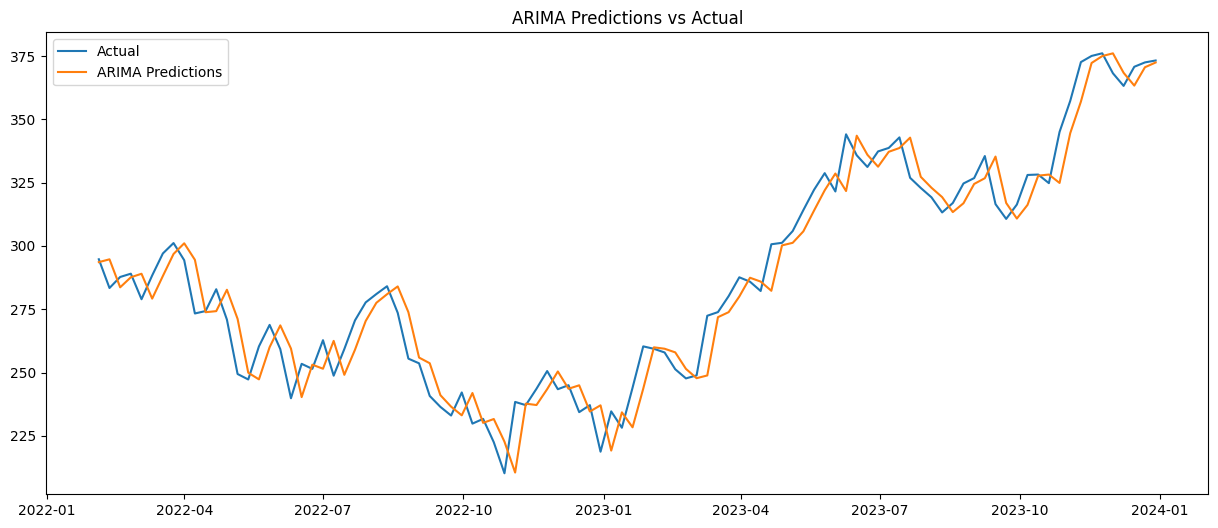

In [38]:


# 3. ARIMA Implementation
# Stationarity test
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

print("Stationarity Test for Log Returns:")
test_stationarity(df['Log_Returns'])

# Fit ARIMA model
arima_model = ARIMA(df['Close'], order=(1,1,1))
arima_results = arima_model.fit()

# Generate ARIMA predictions
arima_predictions = arima_results.predict(start=len(df)-100, end=len(df)-1)

# Plot ARIMA predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(df.index[-100:], df['Close'][-100:], label='Actual')
plt.plot(df.index[-100:], arima_predictions, label='ARIMA Predictions')
plt.title('ARIMA Predictions vs Actual')
plt.legend()
plt.show()

# RNN Model Training

In [39]:


# 4. RNN Implementation
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

# Prepare sequences
def prepare_data(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback)])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

# Split into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare sequences
lookback = 60
X_train, y_train = prepare_data(train_data, lookback)
X_test, y_test = prepare_data(test_data, lookback)

# Build and train RNN Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
print(model.summary())

# Train with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)




Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.5138e-04 - val_loss: 0.0020
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 4.0278e-04 - val_loss: 0.0023
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 4.5604e-04 - val_loss: 0.0015
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 3.7358e-04 - val_loss: 0.0025
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.0944e-04 - val_loss: 0.0018
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.4530e-04 - val_loss: 0.0011
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.3810e-04 - val_loss: 0.0015
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.7458e-04 - val_loss: 0.0015
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.2861e-04 - val_loss: 0.0014
Epoch 12/10

# Model Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Model Performance Metrics:
Train RMSE: 5.41
Test RMSE: 22.23
Train MAE: 4.01
Test MAE: 18.88
Train R²: 0.9905
Test R²: 0.7647

Mean Absolute Percentage Error: 6.83%


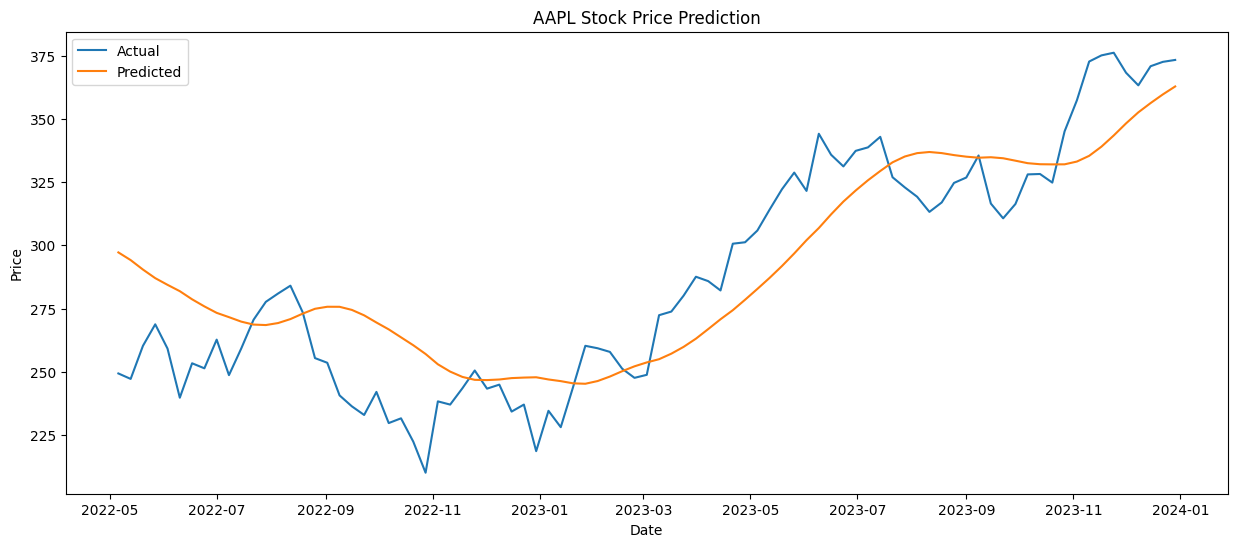

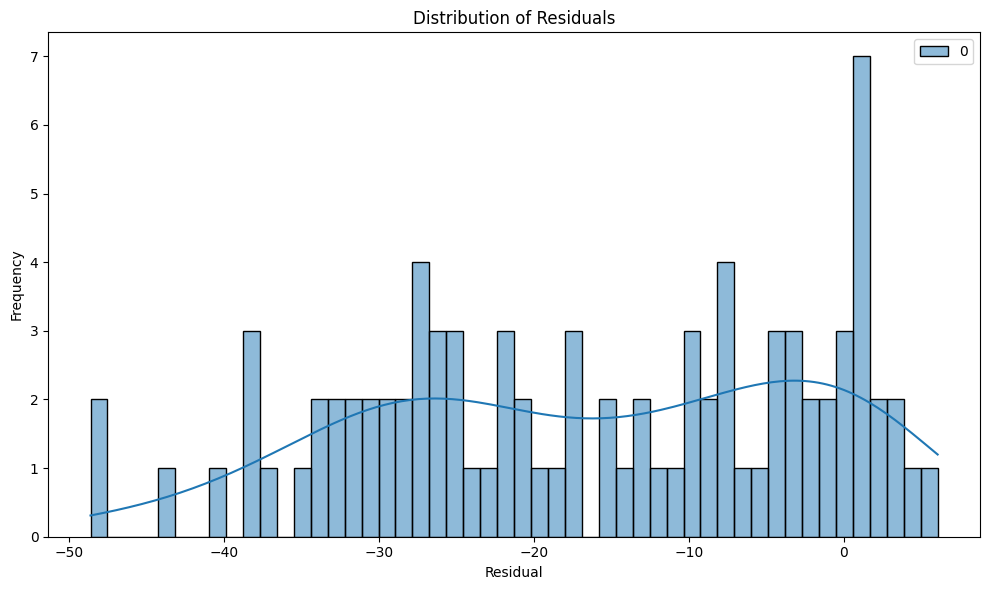

In [40]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
y_train_inv = scaler.inverse_transform([y_train.flatten()])
test_predictions = scaler.inverse_transform(test_predictions)
y_test_inv = scaler.inverse_transform([y_test.flatten()])

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_inv.T, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_inv.T, test_predictions))
train_mae = mean_absolute_error(y_train_inv.T, train_predictions)
test_mae = mean_absolute_error(y_test_inv.T, test_predictions)
train_r2 = r2_score(y_train_inv.T, train_predictions)
test_r2 = r2_score(y_test_inv.T, test_predictions)

print("\nModel Performance Metrics:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Directional Accuracy
def classify_movement(actual, predicted):
    actual_movement = np.diff(actual.flatten()) > 0
    predicted_movement = np.diff(predicted.flatten()) > 0
    return actual_movement, predicted_movement

y_test_movement, test_pred_movement = classify_movement(y_test_inv, test_predictions)

# Additional Metrics
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_inv.T, test_predictions)
print(f"\nMean Absolute Percentage Error: {mape:.2%}")
# Plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(df.index[train_size+lookback:], y_test_inv.T, label='Actual')
plt.plot(df.index[train_size+lookback:], test_predictions, label='Predicted')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()